Initial setup and first topic model run

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

In [3]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [4]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [5]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)
#maybe we don't want to do this for this analysis? older papers less likely to have dois?

Removing 1799 records with no DOIs


In [6]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']

In [7]:
# removed_pubs

In [8]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,AU,SO,title,year
1,"Laner, David|Feketitsch, Julia|Rechberger, Hel...",JOURNAL OF INDUSTRIAL ECOLOGY,A Novel Approach to Characterize Data Uncertai...,2016
2,"Gendy, AS|Saleeb, AF",COMPUTATIONAL MECHANICS,Nonlinear material parameter estimation for ch...,2000
3,"Zhao Yan Jun, |Xu Cheng, |Wang Ya Ping, |Bao, ...",ICIC 2009: SECOND INTERNATIONAL CONFERENCE ON ...,Research on Individual Soldier Automatic Weapo...,2009
4,"Xu, Yue-Ping|Booij, Martijn J.|Mynett, Arthur E.",ENVIRONMENTAL MODELLING & SOFTWARE,An appropriateness framework for the Dutch Meu...,2007
5,"McElwee, CD",JOURNAL OF HYDROLOGY,Improving the analysis of slug tests,2002


In [9]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

In [10]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [11]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(4),
    # 'UA': topic_results.get_topic_by_id(8),
    # 'SA': topic_results.get_topic_by_id(20),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3203

In [12]:
# find paper of interest - see if it's still in the corpora
for i in range(1,6):
    topic_set = topic_results.get_topic_by_id(i)
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = wosis.rc_to_df(topic_recs)
    
    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [13]:
topic_4_set = topic_results.get_topic_by_id(4)

In [14]:
topic_4_set.loc[:, ~topic_4_set.columns.isin(hide_columns)].head(10)

,AU,SO,title,year
0,"Laner, David|Feketitsch, Julia|Rechberger, Hel...",JOURNAL OF INDUSTRIAL ECOLOGY,A Novel Approach to Characterize Data Uncertai...,2016
3,"Xu, Yue-Ping|Booij, Martijn J.|Mynett, Arthur E.",ENVIRONMENTAL MODELLING & SOFTWARE,An appropriateness framework for the Dutch Meu...,2007
6,"Sammen, Saad Sh|Mohamed, T. A.|Ghazali, A. H.|...",NATURAL HAZARDS,An evaluation of existent methods for estimati...,2017
30,"Sloan, Jamison|Sun, Yunwei|Carrigan, Charles",JOURNAL OF ENVIRONMENTAL RADIOACTIVITY,Uncertainty quantification for discrimination ...,2016
33,"Dubus, IG|Janssen, PHM",ENVIRONMENTAL TOXICOLOGY AND CHEMISTRY,Issues of replicability in Monte Carlo modelin...,2003
35,"Hofer, Eduard",HEALTH PHYSICS,How to account for uncertainty due to measurem...,2008
38,"Bastin, Lucy|Cornford, Dan|Jones, Richard|Heuv...",ENVIRONMENTAL MODELLING & SOFTWARE,Managing uncertainty in integrated environment...,2013
42,"Louwerse, Max|Cai, Zhiqiang|Hu, Xiangen|Ventur...",INTERNATIONAL JOURNAL ON ARTIFICIAL INTELLIGEN...,Cognitively inspired NLP-based knowledge repre...,2006
45,"Zorko, Benjamin|Korun, Matjaz|Mora Canadas, Ju...",JOURNAL OF ENVIRONMENTAL RADIOACTIVITY,Systematic influences of gamma-ray spectrometr...,2016
52,"Tao Gang, |Song Huan-sheng, |Yan Yong-gang, |J...",IEEE 12TH INT CONF UBIQUITOUS INTELLIGENCE & C...,Cause Analysis of Traffic Accidents Based on D...,2015


In [15]:
topic_4_recs = wosis.extract_recs(topic_4_set.loc[:, 'id'], RC, 'Topic of Interest')

In [16]:
#run topic model on topic 4
topic_4_subtopics = find_topics(topic_4_set, num_topics=5)

C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Topic 1: uncertainty model uncertainties analysis water data quality models assessment modeling
Topic 2: stochastic polynomial chaos random quantification equations method expansion collocation solution
Topic 3: sensitivity analysis model models global parameters indices input based output
Topic 4: bayesian model data parameter models calibration inference posterior prior estimation
Topic 5: carlo monte sampling method probability simulation failure distribution reliability function


<hr>

Plotting subtopic trends over time <br>
Two topics are chosen, papers focusing on applications of SA and papers focusing on theoretical development of SA <br>
The next task is to plot the category trends over time.

In [17]:
subtopic1 = topic_4_subtopics.get_topic_by_id(1)
subtopic3 = topic_4_subtopics.get_topic_by_id(3)
subtopic4 = topic_4_subtopics.get_topic_by_id(4)

In [18]:
uncertainty_model__applications = wosis.extract_recs(subtopic1['id'], RC, name='applications')

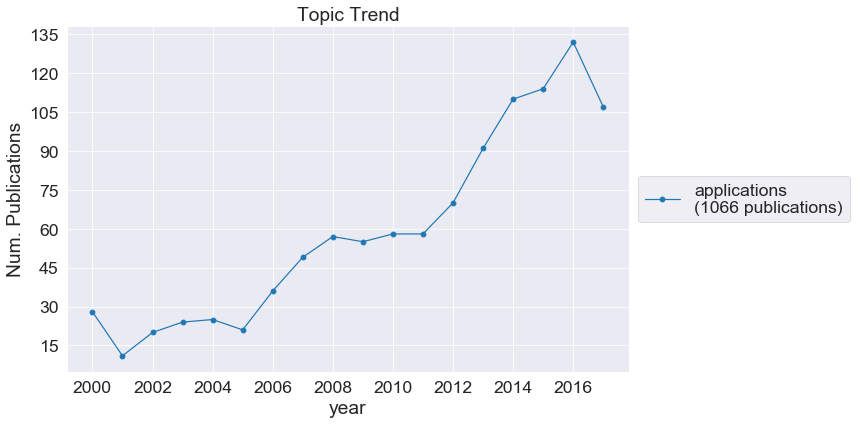

In [19]:
wos_plot.plot_topic_trend([uncertainty_model__applications, ], total_rc=None, title='Topic Trend')

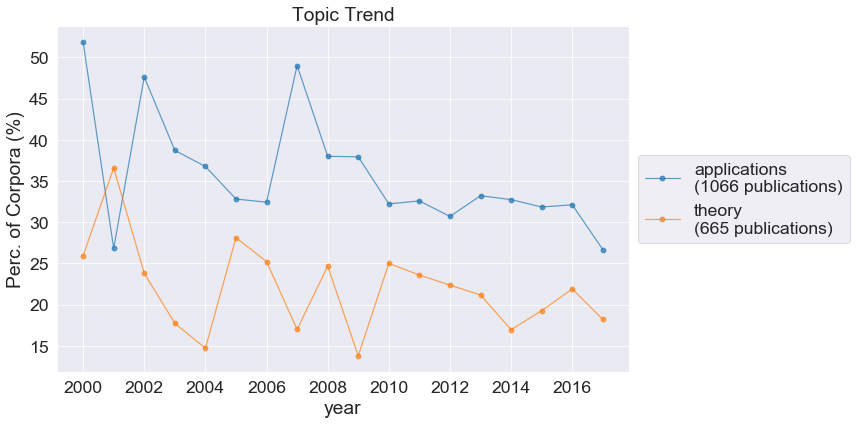

In [20]:
uncertainty_model__sa = wosis.extract_recs(subtopic3['id'], RC, name='theory')

wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=topic_recs, title='Topic Trend')

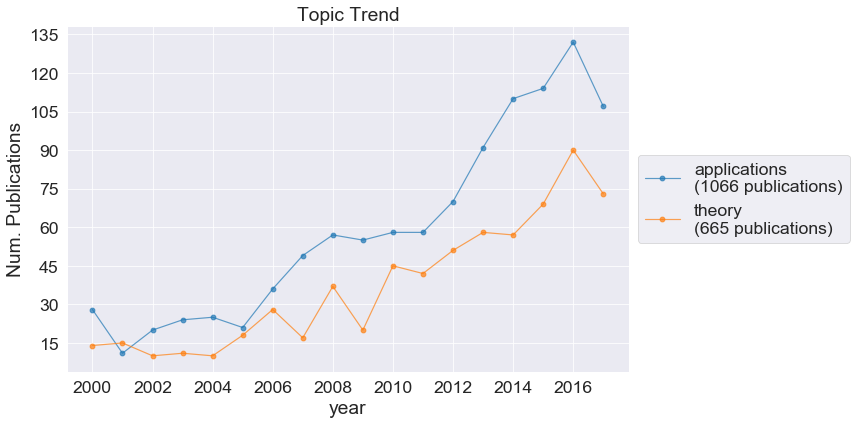

In [21]:
wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=None, title='Topic Trend')

<hr>

Here the results to app_paper are sorted with reference to the packages they support.
<br> Still to complete: plot each criterion's trend

In [22]:
#keyword criteria match on app_papers
#want to see trend of keywords over time
#add languages
uncertainty_topic_df = topic_results.get_topic_by_id(4)

uncertainty_models_rc = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')
# topic_4_1_recs = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')

criteria = {
    'GLUE': set(['GLUE', 'generalized likelihood uncertainty estimation', 'distributed models', 'calibration uncertainty', 'likelihood', 'uncertainty estimation', 'epistemic error', 'rainfall-runoff models', 'equifinality', 'Plynlimon']),
    'PEST': set(['PEST', 'parameter estimation', 'model-independent parameter estimation & uncertainty analysis', 'user interfaces', 'computer systems', 'data processing', 'least squares', 'spatial systems', 'mathematical models', 'software']),
    'SALib': set(['salib', 'sensitivity analysis', 'python', 'uncertainty', 'variance-based', 'global sensitivity analysis', 'fractional factorial', 'method of morris']),
    'MADS': set(['sensitivity analysis', 'MADS', 'julia', 'julialang', 'parameter estimation', 'model inversion & calibration', 'uncertainty quantification', 'model selection', 'model averaging', 'model reduction', 'surrogate modeling', 'machine learning', 'blind source separation', 'decision analysis & support']),
    'PSUADE': set(['uncertainty quantification', 'sensitivity analysis', 'parameter estimation', 'space-filling sample', 'PSUADE', 'Problem Solving environment for Uncertainty Analysis and Design Exploration']),
    'SAFE': set(['global sensitivity analysis', 'matlab', 'octave', 'open-source software', 'safe', 'sensitivity analysis for everyone']),
    'VARS-TOOL': set(['VARS-TOOL', 'VARS', 'global sensitivity analysis', 'uncertainty analysis', 'variogram analysis of response surfaces', 'variogram', 'sobol', 'morris', 'progressive latin hypercube sampling', 'plhs', 'dynamical systems models', 'sensitivty indices', 'performance metrics']),
    'UQLab': set(['uncertainty quantification', 'uncertainty analysis', 'sensitivity analysis', 'computer systems', 'uqlab']),
    'DAKOTA': set(['dakota', 'mathematical methods', 'computing', 'computer-aided design', 'finite element method', 'nonlinear programming', 'sensitivity analysis', 'parallel processing', 'stochastic processes', 'integer processing', 'iterative methods', 'computer programs']),
    'HDMR': set(['global sensitivity analysis', 'hdmr', 'high dimensional model representation', 'matlab', 'matlab software', 'graphic user interface', 'gui']),
    'SimLab': set(['sensitivity analysis', 'uncertainty analysis', 'model development', 'global sensitivity analysis', 'simlab'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_models_rc, criteria, threshold=95.0)

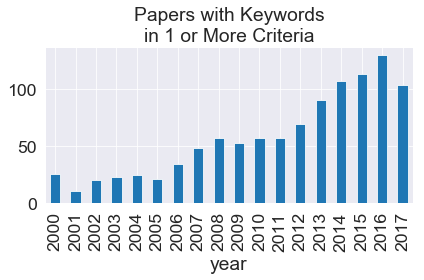

In [23]:
criteria1_df = wosis.collate_keyword_criteria_matches(uncertainty_models_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria1_df, threshold=1)

In [24]:
test = crit_matches['DAKOTA']

dakota_recs = test.combine_recs()

In [25]:
find_topics(dakota_recs)

Topic 1: model paramet predict use analysi estim wa simul method result
Topic 2: flood inund histor map discharg peak inundation damag estim hydraul
Topic 3: decis decision manag criterion altern mcda support framework criteria multicriteria
Topic 4: lca data qualiti method product quality life analysi cycl hybrid
Topic 5: error experiment human systemat precipit quantification stochast random class ed
Topic 6: urban drainag approach rainfallrunoff center common storm land method work
Topic 7: effect treatment error measur covari assumpt effects approxim underestim variabl
Topic 8: load critic exceed deposit site critical input acid wa control
Topic 9: dose dos deposit icrp intern lung public member fraction age
Topic 10: cloud groundwat comput groundwater cluster access computing quantif flexibl possibl


In [26]:
match_res = wosis.keyword_matches(dakota_recs, ['dakota'], threshold=95.0)

In [27]:
dakota_recs = match_res.combine_recs()

In [28]:
dakota_df = wosis.rc_to_df(dakota_recs)

In [29]:
dakota_df['abstract'][1]

'forecasting of hydrologic time series with the quantification of uncertainty is an important tool for adaptive water resources management nonstationarity caused by climate forcing and other factors such as change in physical properties of catchment urbanization vegetation change etc makes the forecasting task too difficult to model by traditional boxjenkins approaches in this paper the potential of the bayesian dynamic modelling approach is investigated through an application to forecast a nonstationary hydroclimatic time series using relevant climate index information the tatet is the time series of the volume of devils lake located in north dakota usa for which it was proved difficult to forecast and quantify the associated uncertainty by traditional methods two different bayesian dynamic modelling approaches are discussed namely a constant model and a dynamic regression model drm the constant model uses the information of past observed values of the same time series whereas the drm

<hr>

The following includes more analysis of the papers from topic 4 and topic 4.3. <br>
- Publication trends
- Criteria matching and trends of criteria.

In [30]:
uncertainty_sa_df = topic_4_subtopics.get_topic_by_id(3)
uncertainty_sa_rc = wosis.extract_recs(uncertainty_sa_df.loc[:, 'id'], topic_recs, 'Topic of Interest')
# tmp_df = wosis.rc_to_df(uncertainty_sa_rc)

In [31]:
uncertainty_sa_df.loc[:, ~topic_set.columns.isin(hide_columns)].head()

,AU,SO,title,year
42,"Louwerse, Max|Cai, Zhiqiang|Hu, Xiangen|Ventur...",INTERNATIONAL JOURNAL ON ARTIFICIAL INTELLIGEN...,Cognitively inspired NLP-based knowledge repre...,2006
52,"Tao Gang, |Song Huan-sheng, |Yan Yong-gang, |J...",IEEE 12TH INT CONF UBIQUITOUS INTELLIGENCE & C...,Cause Analysis of Traffic Accidents Based on D...,2015
68,"Bermudez, Lluis|Ferri, Antoni|Guillen, Montserrat",ASTIN BULLETIN,A CORRELATION SENSITIVITY ANALYSIS OF NON-LIFE...,2013
75,"Miro, S.|Koenig, M.|Hartmann, D.|Schanz, T.",COMPUTERS AND GEOTECHNICS,A probabilistic analysis of subsoil parameters...,2015
79,"Reichert, P.|White, G.|Bayarri, M. J.|Pitman, ...",COMPUTATIONAL STATISTICS & DATA ANALYSIS,Mechanism-based emulation of dynamic simulatio...,2011


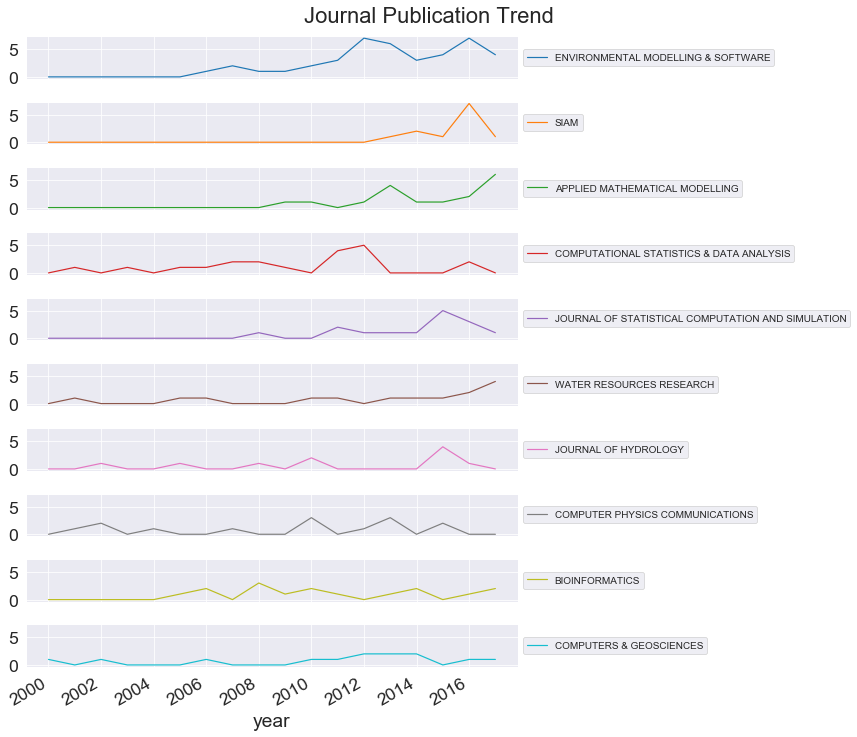

In [32]:
#publication trend for top 10 journals
wos_plot.plot_journal_pub_trend(uncertainty_sa_rc)

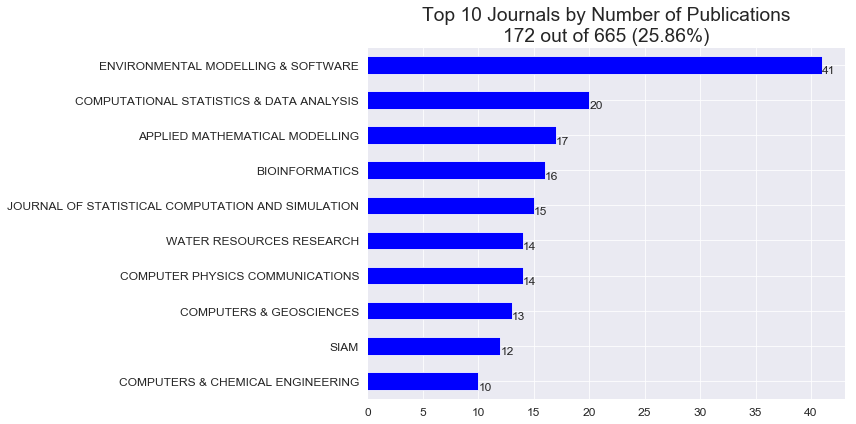

In [33]:
#Top 10 jorunals by number of publications
wos_plot.plot_pubs_per_journal(uncertainty_sa_rc, top_n=10, annotate=True, show_stats=True)

In [34]:
#top papers by cited papers within the corpora
wosis.analysis.pub_citations(uncertainty_sa_rc)[0:5]

#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Saltelli, A, 2000, Sensitivity Analysis, 287467390",328
"Saltelli, A., 2004, Sensitivity Analysis in Practice, A guide to Assesing Scientific Models, 287480276",183
"Sobol, I. M., 1993, Sensitivity analysis for nonlinear mathematical models, Math. Model. Comput. Exp., 1, 407, 2602363",160
"Sobol, IM, 2001, Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates, MATHEMATICS AND COMPUTERS IN SIMULATION, 55, 271, 1049401",111
"Saltelli, Andrea, 2010, How to avoid a perfunctory sensitivity analysis, ENVIRONMENTAL MODELLING & SOFTWARE, 25, 1508, 338424851",99


In [35]:
# first 10 papers in chosen topic (unordered)
uncertainty_sa_doi = wosis.link_to_pub(uncertainty_sa_rc)  # Creates a new column called 'DOI link'
uncertainty_sa_doi.loc[:, ~uncertainty_sa_doi.columns.isin(hide_columns)].head(10)

,AU,SO,title,year,DOI link
0,"Baron, C|Geffroy, JC|Zamilpa, C",COMMUNICATIONS IN NUMERICAL METHODS IN ENGINEE...,Identification of evolutionary sequential syst...,2001,https://dx.doi.org/10.1002/cnm.437
1,"Himpe, Christian|Ohlberger, Mario",MATHEMATICAL PROBLEMS IN ENGINEERING,Cross-Gramian-Based Combined State and Paramet...,2014,https://dx.doi.org/10.1155/2014/843869
2,"He, Li|Huang, Gordon|Lu, Hongwei|Wang, Shuo|Xu...",JOURNAL OF HAZARDOUS MATERIALS,Quasi-Monte Carlo based global uncertainty and...,2012,https://dx.doi.org/10.1016/j.jhazmat.2012.03.067
3,"Waligorski, Piotr|Szaleniec, Maciej",COMPUTATIONAL BIOLOGY AND CHEMISTRY,Prediction of white cabbage (Brassica oleracea...,2010,https://dx.doi.org/10.1016/j.compbiolchem.2010...
4,"Malesios, C.",JOURNAL OF INFORMETRICS,Measuring the robustness of the journal h-inde...,2016,https://dx.doi.org/10.1016/j.joi.2016.03.002
5,"Cho, KH|Shin, SY|Kolch, W|Wolkenhauer, O",SIMULATION-TRANSACTIONS OF THE SOCIETY FOR MOD...,"Experimental design in systems biology, based ...",2003,https://dx.doi.org/10.1177/0037549703040943
6,"Zhang, Hong-yu|Peng, Hong-gang|Wang, Jing|Wang...",APPLIED SOFT COMPUTING,An extended outranking approach for multi-crit...,2017,https://dx.doi.org/10.1016/j.asoc.2017.06.013
7,"Molenberghs, G|Verbeke, C|Thijs, H|Lesaffre, E...",COMPUTATIONAL STATISTICS & DATA ANALYSIS,Influence analysis to assess sensitivity of th...,2001,https://dx.doi.org/10.1016/S0167-9473(00)00065-7
8,"Southwell, Darren M.|Lechner, Alex M.|Coates, ...",CONSERVATION BIOLOGY,The sensitivity of population viability analys...,2008,https://dx.doi.org/10.1111/j.1523-1739.2008.00...
9,"Keaveny, Eric E.|Maxey, Martin R.",JOURNAL OF COMPUTATIONAL PHYSICS,Modeling the magnetic interactions between par...,2008,https://dx.doi.org/10.1016/j.jcp.2008.07.008


In [36]:
uncertainty_sa_doi.to_csv('topic_4_3.csv')

In [37]:
# want to see trend of global SA over years
# also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_sa_rc, criteria, threshold=95.0)

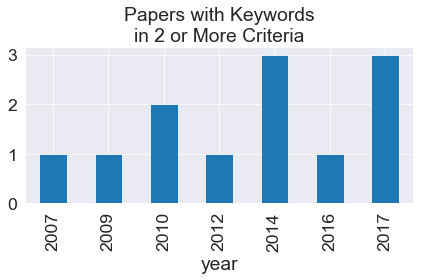

In [38]:
criteria_df = wosis.collate_keyword_criteria_matches(uncertainty_sa_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [39]:
# want to view the papers in the above plot
# crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
# crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

criteria_df.loc[criteria_df['num_criteria_match'] >= 2].sort_values('year').head()

,abstract,id,keywords,title,year,num_criteria_match
439,two different methods for global sensitivity a...,WOS:000253383200010,COUPLED REACTION SYSTEMS|RATE COEFFICIENTS|UNC...,Comparing global sensitivity analysis for a bi...,2007,2
108,global sensitivity analysis techniques are bet...,WOS:000269457200019,RADIOACTIVE-WASTE DISPOSAL|PERFORMANCE ASSESSM...,Global Sensitivity Analysis Techniques for Pro...,2009,2
39,this paper presents an efficient samplingbased...,WOS:000284184800017,INDEXES,Global sensitivity of structural variability b...,2010,2
597,senssb sensitivity analysis for systems biolog...,WOS:000278967500018,,SensSB: a software toolbox for the development...,2010,2
647,when investigating modeling or operating uncer...,WOS:000300862200002,GENERALIZED POLYNOMIAL CHAOS|UNCERTAINTY ANALY...,Global sensitivity analysis: A flexible and ef...,2012,2


In [40]:
lsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['local sensitivity', 'LSA', 'local sensitivity analysis'], threshold=95.0)

In [41]:
gsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['global sensitivity', 'GSA', 'global sensitivity analysis'], threshold=95.0)

In [42]:
oat_matches = wosis.keyword_matches(uncertainty_sa_rc, ['one-at-a-time', 'OAT'], threshold=95.0)

In [43]:
lsa_matches

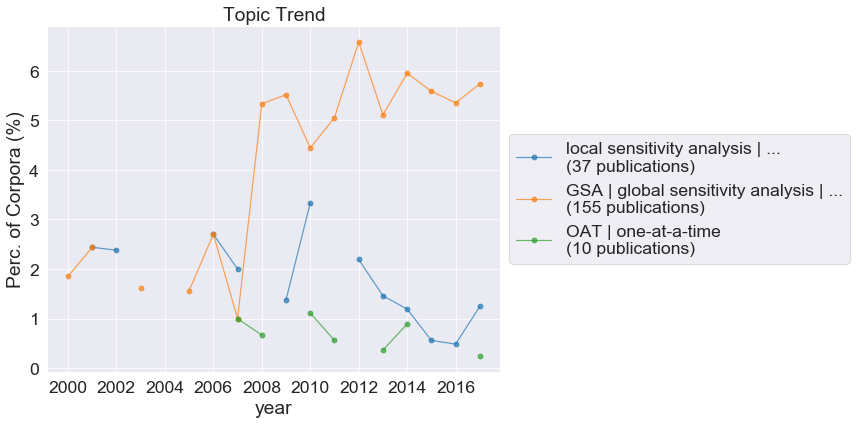

In [44]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches], 
                          topic_4_recs)

<hr>

Network analysis, cocite and coauthor networks
<br> Further formatting/data extraction required, see networkx documentation

In [45]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
# co-author network
coAuths = topic_recs.networkCoAuthor()
print(mk.graphStats(coAuths))

Nodes: 8721
Edges: 21454
Isolates: 148
Self loops: 2
Density: 0.000564229
Transitivity: 0.841433


C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))
C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


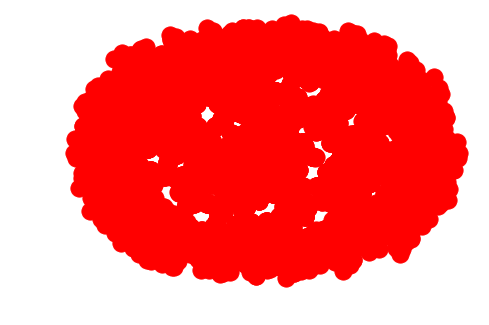

In [47]:
nx.draw_spring(coAuths, with_labels=False)

In [48]:
# highly cited co-atuhor network, how do I limit nodes? Needs to use topic 1 only, not full data base
minWeight = 3
maxWeight = 10
proccessedcoAuths = coAuths.copy()
mk.dropEdges(proccessedcoAuths, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths)

'Nodes: 8721\nEdges: 271\nIsolates: 8427\nSelf loops: 0\nDensity: 7.12716E-06\nTransitivity: 0.754757'

In [49]:
mk.dropNodesByDegree(proccessedcoAuths, 1)
mk.graphStats(proccessedcoAuths)

'Nodes: 294\nEdges: 271\nIsolates: 0\nSelf loops: 0\nDensity: 0.00629194\nTransitivity: 0.754757'

C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


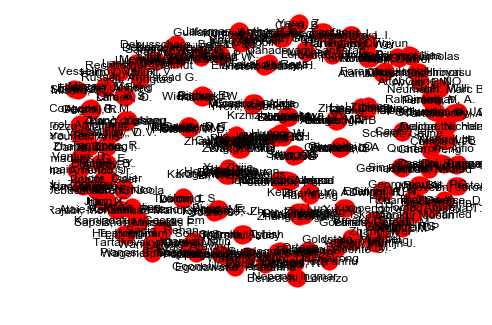

In [50]:
nx.draw_spring(proccessedcoAuths, with_labels=True)

In [51]:
minWeight = 30
maxWeight = 35
coCites = uncertainty_sa_rc.networkCoCitation()
mk.dropEdges(coCites, minWeight, maxWeight, dropSelfLoops=True)
mk.dropNodesByDegree(coCites, 5)
print(mk.graphStats(coCites))

Nodes: 49
Edges: 51
Isolates: 0
Self loops: 0
Density: 0.0433673
Transitivity: 0.0372671


C:\UserData\takuyai\Miniconda3\envs\biblio\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


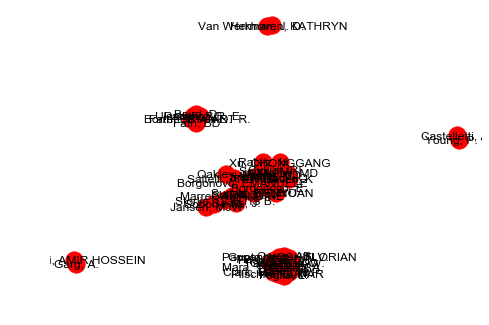

In [52]:
nx.draw_spring(coCites, with_labels=True)